# LCPA 23-24 - "Hierarchical mergers of binary black holes"

<center><h1>Group 07</h1></center>


<center><style>
table {
    font-size: 24px;
}
</style></center>

| Last Name          | First Name            |Student Number|
|--------------------|-----------------------|----------------|
| Bertinelli         | Gabriele              |2103359         |
| Boccanera          | Eugenia               |                |
| Cacciola           | Martina               |2097476         |
| Lovato             | Matteo                |                |           

## 1. Introduction

A binary black hole (BBH) can form via close encounters of black holes (BHs) in a dense stellar environment, such as a nuclear star cluster (NSC), a globular cluster (GC) or a young star cluster (YSC). NSCs are very massive (~ $10^5 - 10^8 \, M_\odot$) star clusters lying at the center of some galaxies, including the Milky Way. GCs are old (~ 12 Gyr) massive (~ $10^4 - 10^6 M_\odot$) stellar clusters lying in the halo of galaxies. YSC are young (< 100 Myr) stellar clusters forming mostly in the disk of a galaxy.  

Several channels can lead to the formation of BBHs. But the distinctive signatures of the dynamical scenario is the formation of hierarchical mergers (IMs), i.e. repeated mergers of stellar-origin BHs that build up more massive one. This process is possible only in dense star clusters, where the merger remnant, which is initially a single BH, can pair up by dynamical exchanges or three-body encounter. The main obstacle to the formation of second-generation BHs via hierarchical mergers is the relativistic kick that the merger remnant receives at birth. This kick can be up to several thousand km/s. Hence, the interplay between the properties of the host star cluster (e.g., its escape velocity), those of the first-generation BBH population and the magnitude of the kick decides the maximum mass of a merger remnant in a given environment.  

A property that is being studied is that IM can build up IMBHs and also partially fill the pair instability (PI) mass gap between ~60 and ~120 $M_\odot$, explaining the formation of BBHs like GW190521.

#### Hierarchical mergers
When two stellar-born BHs merge via GW emission, their merger remnant is called second-generation (2g) BH. The 2g BH is a single object at birth. However, if it is retained inside its host star cluster, it may pair up dynamically with another BH. This gives birth to what we call a second-generation (2g) BBH, i.e. a binary black hole that hosts a 2g black hole . If a 2g binary black hole merges again, it gives birth to a third-generation (3g) BH, and so on. In this way, repeated black hole mergers in star clusters can give birth to hierarchical chains of mergers, leading to the formation of more and more massive black holes.

## 2. Goal of the project

Understand the differences between hierarchical binary black hole mergers in NSCs, GCc and YSc, by looking at a set of simulated BBHs. 
Our analysis will be carried out with classification ML algorithms, such as Random Forest and XGBoost. We will then proceed to analyze the importance of features in order to understand the properties of systems of BBHs.   

The idea is to split the analysis into two parts:

- Based on the features of the BBHs systems, figure out to which host star cluster these systems belong. 
  It's a classification problem with label the `label` column of the dataset corresponding to `0 -> GC, 1 -> NSC, 2 -> YSC`. Feature importance analysis will tell us which features are most important to understand which system belongs to which host stellar cluster.

- Analyze each stellar cluster independently. To do this we added a new label column `label_ngen`: `0` if the system has no other mergers beyond the 2nd generation; `1` if the system evolves beyond the 2nd generation.
  This is still a classification problem, this time with respect to `label_ngen`. Analysis of features importance will tell us which features are most important that lead systems to evolve and which do not.

To do this in a more detailed way, both globally (all labels together) and locally (single label), we will use `SHAP` values (Section ).

In order to have a cleaner notebook we created a file (`hmbh.py`) containing the functions needed to create the dataset, to train the ML models and to plot the results.

# 3. Dataset

The dynamical simulation were run for each host star cluster, with 12 different metallicities each. The files are found in the folders and subfolders: 

```python
folder = ['GC_chi01_output_noclusterevolv', 'NSC_chi01_output_noclusterevolv',
               'YSC_chi01_output_noclusterevolv']
    
metallicity = ['0.0002', '0.002', '0.02', '0.0004', '0.004', '0.006', '0.0008',
                   '0.008', '0.0012', '0.012', '0.0016', '0.016']
```

Each `nth_generation.txt` dataset is composed of 28 columns. Among them we selected these: 

```python
cols = ['c0', 'c1', 'c2', 'c3', 'c4', 'c7', 'c8', 'c9', 'c13', 'c15', 'c16', 'c17', 'c25', 'c27']
```

- c0: Identifier of the binary
- c1: Mass of the primary black hole in solar masses
- c2: Mass of the secondary black hole
  
- c3: Dimensionless spin magnitude of the primary black hole
- c4: Dimensionless spin magnitude of the secondary black hole
- c7: Initial semi-major axis of the binary black hole in solar radii
- c8: Initial orbital eccentricity of the binary black hole

- c9: Time requested for the dynamical pair up of the system in Myr
- c13: Time elapsed since the first-gen formation until the merger of the nth-gen system

- c15: Mass of the remnant
- c16: Dimensionless spin magnitude of the remnant black hole
- c17: Escape velocity from star cluster in km/s
- c25: Total mass of the stellar cluster
- c27: Number of generation of the system

We added two new columns, in the creation of the dataset:
- `label`: Identifies to which host star cluster a system belongs `0 -> GC, 1 -> NSC, 2 -> YSC`
- `label_ngen`: `0` if the system has no other mergers beyond the 2nd generation; `1` if the system evolves beyond the 2nd generation

### Import modules

In [27]:
import hmbh as h # custom module for data analysis

import numpy as np
import pandas as pd
import polars as pl

import matplotlib as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier

## 3.1 Dataset creation

In order to create the dataset we use the custom function `create_dataset`. It used the `polars.DataFrame` object. 
Polars is fast DataFrame library for manipulating structured data. In order to be fast it optimizes queries to reduce unneeded work/memory allocations and adheres to a strict schema (data-types should be known before running the query). 
Polars leverages the concept of `LazyFrame`, Polars doesn't run each query line-by-line but instead processes the full query end-to-end. This lazy evaluation strategy allows for better memory management, making it possible to work with datasets that are too large to fit into RAM (it inherits the concept of "lazy" from Dask).

The speed-up is astonishing: an improvement of ~ 900% wrt using Pandas!

In the creation of the dataset we filter out those systems that take longer than Hubble time (~ 13.6 Gyr) to merge.
After creating the dataset, we rename the columns and we add the column `label_ngen`.

In [3]:
path = '../project/data/'

folder = ['GC_chi01_output_noclusterevolv', 'NSC_chi01_output_noclusterevolv',
               'YSC_chi01_output_noclusterevolv']
    
metallicity = ['0.0002', '0.002', '0.02', '0.0004', '0.004', '0.006', '0.0008',
                   '0.008', '0.0012', '0.012', '0.0016', '0.016']

cols = ['c0', 'c1', 'c2', 'c3', 'c4', 'c7', 'c8', 'c9', 'c13', 'c15', 'c16', 'c17', 'c25', 'c27'] # select bold columns -> most important for this analysis

new_cols = ['ID', 'bh_mass1', 'bh_mass2', 'spin1', 'spin2', 'semimajor', 'i_ecc', 'time_dyn', 'time_merge', 
'remnant_mass', 'remnant_spin', 'escape_vel', 'cluster_mass', 'n_gen']


df = h.create_dataset(path, folder, metallicity, cols) # dataset creation

df = h.rename_columns(df, new_cols) # rename columns

df = h.get_label_ngen(df) # get label for n_gen

In [4]:
df.head(5)

ID,bh_mass1,bh_mass2,spin1,spin2,semimajor,i_ecc,time_dyn,time_merge,remnant_mass,remnant_spin,escape_vel,cluster_mass,n_gen,label,met,label_ngen
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,f64,i32
"""2.0.0""",28.497396,23.848129,0.734705,0.014536,118.322458,0.660875,73.920947,1746.620064,49.029268,0.816124,43.17523,456627.739325,2,0,0.0002,0
"""18.0.0""",38.172095,29.913274,0.753993,0.161852,378.031535,0.406799,38.064151,1712.47759,63.511846,0.840459,42.843056,375550.638468,2,0,0.0002,0
"""34.0.0""",60.53033,53.519905,0.720625,0.162188,608.965749,0.936663,240.687784,2461.291832,106.560909,0.825812,118.780296,5.4067e6,2,0,0.0002,0
"""38.0.0""",14.480868,13.043004,0.725751,0.111623,219.843013,0.361773,691.059977,7757.376544,25.747022,0.81898,76.422227,1.6841e6,2,0,0.0002,0
"""103.0.0""",19.224383,15.611048,0.742771,0.208234,28.765131,0.490608,2000.834621,7287.34974,32.475861,0.840732,103.880881,4.2546e6,2,0,0.0002,0


# 4. Visual description
Below we plot some important features and we provide a description of their distribution and relation with the host star cluster and the number of generations.

### 4.1 Masses

# 5. Classification analysis

In this section we describe the machine learning tasks and their results.

### 5.1 Data preprocessing

With `h.data_preprocessing` we prepare the dataset for the training and testing of the ML model.  
One important parameter is `balanced_label`. Having a balanced label dataset for a classifier. In our dataset very few systems, wrt other labels, belongs to `label` = 2 (YSC). This is a problem if we restrict the dataset to less samples than the total (i.e. using the `n_sample` parameter). In fact, on the restricted dataset the models struggle to generalize over the label 2. So if we decide to restrict our dataset is mandatory to balance the labels (and the maximum number of samples will be label_2 $\times$ 3).

Here below we show what we said above. We train a simple Random Forest (RF) model three times: 
- Full dataset w/o balanced labels
- Restricted dataset w/o balanced labels
- Restricted dataset w/ balanced labels

'+' 

model_evaluation w/o bar_plot to show difference in label performance.

##### 5.1.1 Full dataset w/o balanced labels

To run the simulation over the entire dataset it takes ~ 6 min 30 sec. We gain a pretty high accuracy on the test score, ~97%. But if we look at the confusion matrix, that tells us how the model had classified the samples, we see that ~50% of the label 2 are predicted as label 0. This is due to the fact that the label count of label 2 is 2 (3) order less than label 0 (1). The labels, in the complete dataset are unbalanced and lead to a bad generalization over unseen data.


Label count after sampling:
 label
1    2788313
0     433627
2       7207
Name: count, dtype: int64

X_train shape: (2583317, 13)
X_test shape: (645830, 13)
y_train shape: (2583317,)
y_test shape: (645830,)

Training Score:        0.9979839872535968
Test score (Accuracy): 0.971031076289426



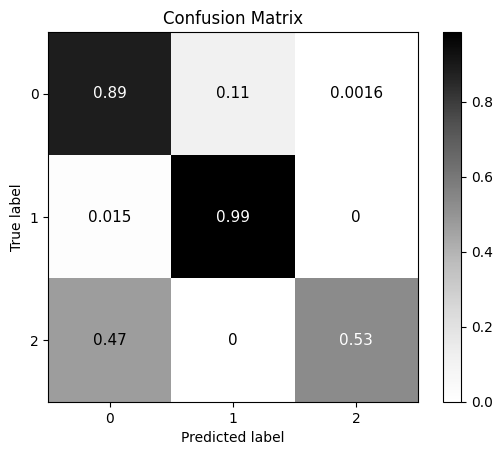

In [5]:
X, y, X_train, y_train, X_test, y_test = h.data_preprocessing(df, n_sample=None, label='label', test_size=0.2, balanced_label=False)

RF, y_pred = h.simple_RF(X_train, y_train, X_test)

h.model_evaluation(RF, X, y, X_train, y_train, X_test, y_test, y_pred, bar_plot=False) # bar_plot=False because we don't want asses features importance

##### 5.1.2 Restricted dataset w/o balanced labels
This time we take 100.000 samples, among all the labels, that correspond to ~3% of the dataset. The label are unbalanced and in fact we can notice that label 2 is stille 2 (3) order less than the other two labels. The results are the same as before.  
This time we also do a test with `label_ngen` and we can see that label 0 is mis-labelled ~50% of the times.


Label count after sampling:
 label
1    86549
0    13240
2      211
Name: count, dtype: int64

X_train shape: (80000, 13)
X_test shape: (20000, 13)
y_train shape: (80000,)
y_test shape: (20000,)

Training Score:        0.998
Test score (Accuracy): 0.9706



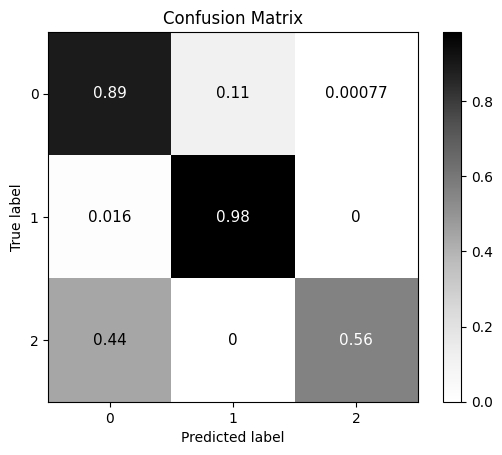

In [7]:
X, y, X_train, y_train, X_test, y_test = h.data_preprocessing(df, n_sample=100_000, label='label', test_size=0.2, balanced_label=False)

RF, y_pred = h.simple_RF(X_train, y_train, X_test)

h.model_evaluation(RF, X, y, X_train, y_train, X_test, y_test, y_pred, bar_plot=False) # bar_plot=False because we don't want asses features importance


Label count after sampling:
 label_ngen
0    87483
1    12517
Name: count, dtype: int64

X_train shape: (80000, 13)
X_test shape: (20000, 13)
y_train shape: (80000,)
y_test shape: (20000,)

Training Score:        0.9889625
Test score (Accuracy): 0.93795



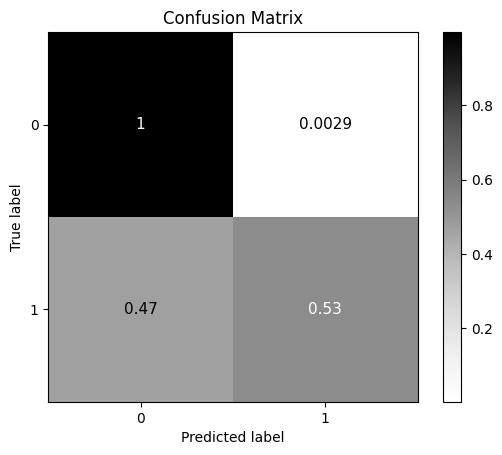

In [9]:
X, y, X_train, y_train, X_test, y_test = h.data_preprocessing(df, n_sample=100_000, label='label_ngen', test_size=0.2, balanced_label=False)

RF, y_pred = h.simple_RF(X_train, y_train, X_test)

h.model_evaluation(RF, X, y, X_train, y_train, X_test, y_test, y_pred, bar_plot=False)


##### 5.1.3 Restricted dataset w/ balanced labels

In this case either we downsample or not, the dataset will have $n_{sample} \le 7207\cdot3 = 21621$, that is ~0.66% of the complete dataset.  
This time, thanks to the balanced dataset, the labels are classified correctly with great accuracy ($\ge 88\,\%$). The test accuracy remains high, ~92%. 

Regarding the classification problem with `label_ngen`, the dataset will have $n_{sample} \le 401335\cdot2 = 802670$, that is ~24% of the complete dataset. We can downsample the dataset in order to gain some computational speed. 
The test accuracy is around ~79% and the correct predictions are ~87% and ~71%, for 0 and 1. This is an acceptable result but we have to keep in mind that we are working with a simple model.

Label count before balancing:
 label
1    2788313
0     433627
2       7207
Name: count, dtype: int64 

Label count after balancing:
 label
1    7207
0    7207
2    7207
Name: count, dtype: int64

Label count after sampling:
 label
1    7207
0    7207
2    7207
Name: count, dtype: int64

X_train shape: (17296, 13)
X_test shape: (4325, 13)
y_train shape: (17296,)
y_test shape: (4325,)

Training Score:        0.9943917668825162
Test score (Accuracy): 0.9197687861271676



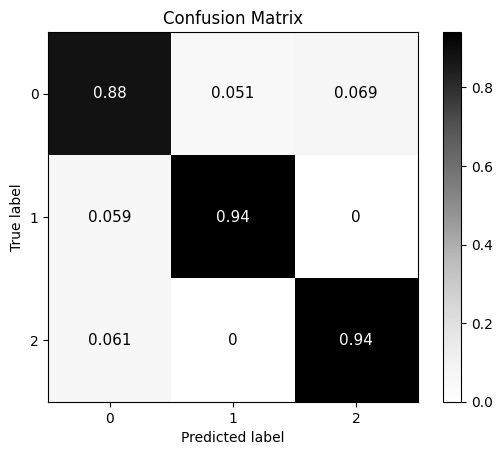

In [14]:
X, y, X_train, y_train, X_test, y_test = h.data_preprocessing(df, n_sample=None, label='label', test_size=0.2, balanced_label=True)

RF, y_pred = h.simple_RF(X_train, y_train, X_test)

h.model_evaluation(RF, X, y, X_train, y_train, X_test, y_test, y_pred, bar_plot=False)

Label count before balancing:
 label_ngen
0    2827812
1     401335
Name: count, dtype: int64 

Label count after balancing:
 label_ngen
0    401335
1    401335
Name: count, dtype: int64

Label count after sampling:
 label_ngen
0    50012
1    49988
Name: count, dtype: int64

X_train shape: (80000, 13)
X_test shape: (20000, 13)
y_train shape: (80000,)
y_test shape: (20000,)

Training Score:        0.9863875
Test score (Accuracy): 0.79195



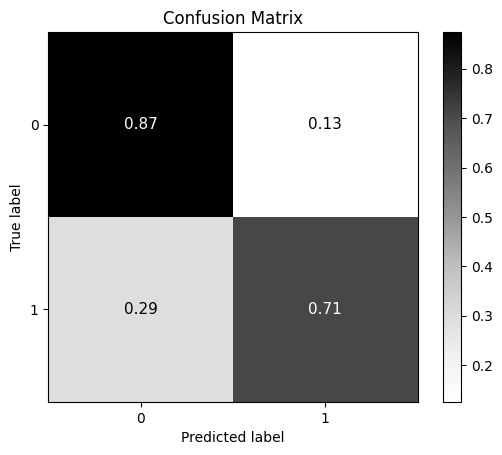

In [18]:
X, y, X_train, y_train, X_test, y_test = h.data_preprocessing(df, n_sample=100_000, label='label_ngen', test_size=0.2, balanced_label=True)

RF, y_pred = h.simple_RF(X_train, y_train, X_test)

h.model_evaluation(RF, X, y, X_train, y_train, X_test, y_test, y_pred, bar_plot=False)

We do not propose a similar analysis with `XGBoost` for brevity. The results are the same as for the RF.  
So, given the results above, we can conclude that the best way is to work with a balanced dataset in order to have a better generalization over unseen data, thus improving model evaluation.

We've also seen that we can reduce the number of samples while retaining a good accuracy score. The next step is to understand what is the optimal size of the sample dataset.

## 5.2 Best dataset size

In this section we'll propose an analysis to understand which is the best sample size without loosing too much accuracy. This is done in order to gain computational speed.  
We'll use `plot_learning_curve` function. This function takes in input the data that we want to analyze and the ML model. It uses the `sklearn` `learning_curve` function to calculate the mean training/test scores. The `sklearn` function divides the input data in training set of different sizes.  
We can see that 14000 trining samples provides a good result for the mean test score. So we can guess that the finale model will have high accuracy if we use 18000 samples (that is a bit more that the sum of the training samples and the test samples, given the fact that we choose to use a test size of 20%).  



Label count before balancing:
 label
1    2788313
0     433627
2       7207
Name: count, dtype: int64 

Label count after balancing:
 label
1    7207
0    7207
2    7207
Name: count, dtype: int64

Label count after sampling:
 label
1    7207
0    7207
2    7207
Name: count, dtype: int64

X_train shape: (17296, 13)
X_test shape: (4325, 13)
y_train shape: (17296,)
y_test shape: (4325,)


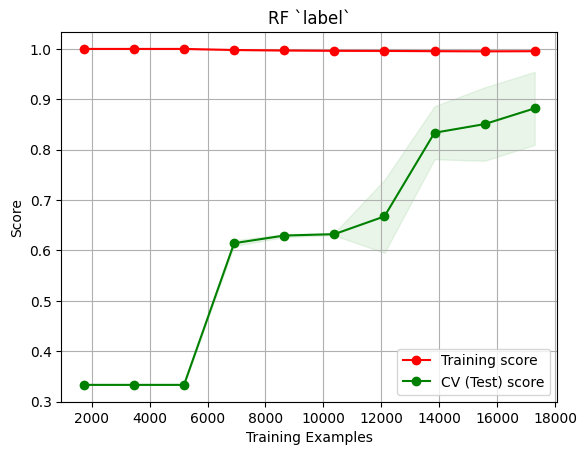

In [26]:
# `label` balanced dataset. Not downsampled

X, y, X_train, y_train, X_test, y_test = h.data_preprocessing(df, n_sample=None, label='label', test_size=0.2, balanced_label=True)

RF = RandomForestClassifier(n_estimators=10, class_weight='balanced_subsample', criterion='entropy', random_state=42) # simple RF model. The same used above

h.plot_learning_curve(RF, X, y, cv=5, title='RF `label`', train_sizes=np.linspace(0.1, 1.0, 10))

Label count before balancing:
 label
1    2788313
0     433627
2       7207
Name: count, dtype: int64 

Label count after balancing:
 label
1    7207
0    7207
2    7207
Name: count, dtype: int64

Label count after sampling:
 label
1    7207
0    7207
2    7207
Name: count, dtype: int64

X_train shape: (17296, 13)
X_test shape: (4325, 13)
y_train shape: (17296,)
y_test shape: (4325,)


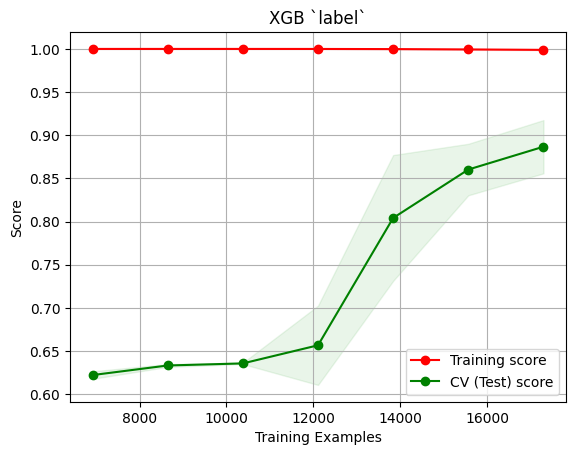

In [28]:
# `label` balanced dataset. Not downsampled

params = {
            'objective': 'binary:logistic',
            'eval_metric': 'logloss'
        }

X, y, X_train, y_train, X_test, y_test = h.data_preprocessing(df, n_sample=None, label='label', test_size=0.2, balanced_label=True)

XGB = XGBClassifier(random_state=42, tree_method='approx', n_jobs=4, **params,)

h.plot_learning_curve(XGB, X, y, cv=5, title='XGB `label`', train_sizes=np.linspace(0.1, 1.0, 10))

In [29]:
# `label_ngen` balanced dataset. Not downsampled

X, y, X_train, y_train, X_test, y_test = h.data_preprocessing(df, n_sample=None, label='label_ngen', test_size=0.2, balanced_label=True)

RF = RandomForestClassifier(n_estimators=10, class_weight='balanced_subsample', criterion='entropy', random_state=42) # simple RF model. The same used above

h.plot_learning_curve(RF, X, y, cv=5, title='RF `label_ngen`', train_sizes=np.linspace(0.1, 1.0, 10))

Label count before balancing:
 label_ngen
0    2827812
1     401335
Name: count, dtype: int64 

Label count after balancing:
 label_ngen
0    401335
1    401335
Name: count, dtype: int64

Label count after sampling:
 label_ngen
0    401335
1    401335
Name: count, dtype: int64

X_train shape: (642136, 13)
X_test shape: (160534, 13)
y_train shape: (642136,)
y_test shape: (160534,)


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [ ]:
# `label_ngen` balanced dataset. Not downsampled

params = {
            'objective': 'binary:logistic',
            'eval_metric': 'logloss'
        }

X, y, X_train, y_train, X_test, y_test = h.data_preprocessing(df, n_sample=None, label='label_ngen', test_size=0.2, balanced_label=True)

XGB = XGBClassifier(random_state=42, tree_method='approx', n_jobs=4, **params,)

h.plot_learning_curve(XGB, X, y, cv=5, title='XGB `label_ngen`', train_sizes=np.linspace(0.1, 1.0, 10))